<a href="https://colab.research.google.com/github/johanjan/swallow/blob/master/grade2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3")
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil
import numpy as np 


dolfin_version = dolfin.__version__
print('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [81.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Get:9 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 https://developer.dow

   IPM iter_no= 0 div_u_norm=  5.13948e-03
   IPM iter_no= 1 div_u_norm=  2.11741e-05
   IPM iter_no= 2 div_u_norm=  8.78071e-08
   IPM iter_no= 3 div_u_norm=  3.64495e-10
   IPM iter_no= 4 div_u_norm=  3.08306e-12
Stokes solver  IPM iter_no= 5 div_u_norm=  3.08e-12
   IPM iter_no= 0 div_u_norm=  5.16e-03
   IPM iter_no= 1 div_u_norm=  2.14e-05
   IPM iter_no= 2 div_u_norm=  8.91e-08
   IPM iter_no= 3 div_u_norm=  3.72e-10
   IPM iter_no= 4 div_u_norm=  3.06e-12
   IPM iter_no= 5 div_u_norm=  3.06e-12
Newton iter_no= 1 Delta_u_norm=  1.51e-02 u_norm=  9.46e+00 div_u_norm=  6.14e-12
   IPM iter_no= 0 div_u_norm=  5.16e-03
   IPM iter_no= 1 div_u_norm=  2.14e-05
   IPM iter_no= 2 div_u_norm=  8.91e-08
   IPM iter_no= 3 div_u_norm=  3.72e-10
   IPM iter_no= 4 div_u_norm=  3.06e-12
   IPM iter_no= 5 div_u_norm=  3.06e-12
Newton iter_no= 2 Delta_u_norm=  5.78e-08 u_norm=  9.46e+00 div_u_norm=  9.20e-12
p_in:  -14.529189229170736
p_out:  45.21546604070278
p_delta:  -59.74465526987352 

 Pres

/usr/lib/python3/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)
/usr/lib/python3/dist-packages/dolfin/common/plotting.py:152: UserWarning: The following kwargs were not used by contour: 'interactive'
  return ax.tricontourf(mesh2triang(mesh), C, levels, **kwargs)


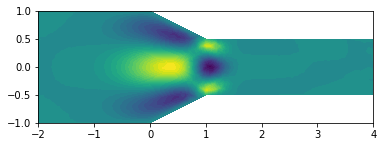

In [0]:
"""This program solves the grade-two non-Newtonian fluid model equations
in an expanding duct with Dirichlet boundary conditions given by 
u=(1-y^2,0) on the left,  u = (0.5(1-0.25*y^2),0) on the right and
u=0 elsewhere.
The boundary conditions for z are posed only on the inflow boundary
"""
from mshr import *
from dolfin import *
import math,sys

set_log_active(False)

#meshsize=int(sys.argv[1])
#reno=float(sys.argv[2])
#alfa=float(sys.argv[3])
#rbufr=float(sys.argv[4])

meshsize=int(32)
reno=float(0.2)
alfa=float(0.1)


realf=reno*alfa

upright=0.5
right=1.0
lbufr=-2.0
rbufr=3.0
fudg=10000
pdeg=4


def in_bdry(x):
  return x[0] < lbufr+DOLFIN_EPS 

# create mesh and define velocity and pressure function spaces 
domain =  Polygon([dolfin.Point(lbufr, -1.0),\
                   dolfin.Point( 0.0, -1.0),\
                   dolfin.Point(right, -upright),\
                   dolfin.Point(right+rbufr, -upright),\
                   dolfin.Point(right+rbufr,  upright),\
                   dolfin.Point(right,  upright),\
                   dolfin.Point(0.0,  1.0),\
                   dolfin.Point(lbufr,  1.0)])

# Create mesh and define function space
mesh   = generate_mesh(domain, meshsize)
newmesh = refine(mesh)
newmesh = refine(newmesh)
W = VectorFunctionSpace(newmesh, "Lagrange", 1)

V = VectorFunctionSpace(mesh, "Lagrange", pdeg)
Z = FunctionSpace(mesh, "Lagrange", pdeg)
# define boundary condition
boundary_exp = Expression(("exp(-fu*(lb-x[0])*(lb-x[0]))*(1.0-x[1]*x[1]) + \
  (1.0/up)*exp(-fu*(ri+rb-x[0])*(ri+rb-x[0]))*(1.0-((x[1]*x[1])/(up*up)))","0"), \
                   up=upright,ri=right,fu=fudg,rb=rbufr,lb=lbufr, degree=4)
boundary_zee = Expression("exp(-fu*(lb-x[0])*(lb-x[0]))*(2.0*x[1]) + \
           exp(-fu*(ri+rb-x[0])*(ri+rb-x[0]))*(2.0*x[1]/(up*up*up))", \
                   up=upright,ri=right,fu=fudg,rb=rbufr,lb=lbufr, degree=4)
#boundary_zee = Expression("0.0")

bc = DirichletBC(V, boundary_exp, "on_boundary")
#bczee = DirichletBC(Z, boundary_zee, "on_boundary")
bczee = DirichletBC(Z, boundary_zee, in_bdry)
# set the parameters
zf = Expression(("0","0"), degree=4)
bcz = DirichletBC(V, zf, "on_boundary")
r = 1.0e4
# define test and trial functions, and function that is updated
uold = TrialFunction(V)
gold = TrialFunction(V)
zee = TrialFunction(Z)
v = TestFunction(V)
w = Function(V)
w = project(zf,V)
asf = inner(grad(uold), grad(v))*dx + r*div(uold)*div(v)*dx 
asg = (inner(grad(gold),grad(v)) + r*div(gold)*div(v))*dx            \
#      +reno*zee*(v[0]*gold[1]-v[1]*gold[0]) \
#       +r*div(gold)*div(v))*dx
bs = -div(w)*div(v)*dx
uold = Function(V)
ust = Function(V)
pdes = LinearVariationalProblem(asf, -bs, uold, bc)
solvers = LinearVariationalSolver(pdes)
# Stokes solution
# Scott-Vogelius iterated penalty method
iters = 0; max_iters = 5; div_u_norm = 1
while iters < max_iters and div_u_norm > 1e-10:
# solve and update w
    solvers.solve()
    w.vector().axpy(-r, uold.vector())
# find the L^2 norm of div(u) to check stopping condition
    div_u_norm = sqrt(assemble(div(uold)*div(uold)*dx(mesh)))
    print( "   IPM iter_no=",iters,"div_u_norm="," %.5e"%div_u_norm)
    iters += 1
print( "Stokes solver  IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
#plot(uold[0], interactive=True)
#plot(div(uold), interactive=True)
uold.set_allow_extrapolation(True)
seeu=interpolate(uold,W)
#plot(seeu[0], interactive=True)
ust.vector().axpy(1.0, uold.vector())
# ust is the Stokes solution
# Navier-Stokes solver
kters = 0; max_kters = 9; unorm = 1
while kters < max_kters and unorm > 1e-6:
    u = TrialFunction(V)
    v = TestFunction(V)
    w = Function(V)
    w = project(zf,V)
#   uold = Function(V)
    a = inner(grad(u), grad(v))*dx + r*div(u)*div(v)*dx \
      +reno*inner(grad(uold)*u,v)*dx+reno*inner(grad(u)*uold,v)*dx 
    b = -div(w)*div(v)*dx
    F = inner(grad(uold), grad(v))*dx+reno*inner(grad(uold)*uold,v)*dx
    u = Function(V)
    pde = LinearVariationalProblem(a, F - b, u, bcz)
    solver = LinearVariationalSolver(pde)
# Scott-Vogelius iterated penalty method
    iters = 0; max_iters = 10; div_u_norm = 1
#   iters = 0; max_iters = max(2,kters); div_u_norm = 1
    while iters < max_iters and div_u_norm > 1e-10:
    # solve and update w
        solver.solve()
        w.vector().axpy(-r, u.vector())
    # find the L^2 norm of div(u) to check stopping condition
        div_u_norm = sqrt(assemble(div(u)*div(u)*dx(mesh)))
        print( "   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
        iters += 1
    print( "   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
    kters += 1
    uold.vector().axpy(-1.0, u.vector())
#   plot(uold[0], interactive=True)
#   uold=uold-u
    unorm=norm(u,norm_type='H1')
    uoldnorm=norm(uold,norm_type='H1')
    div_u_norm = sqrt(assemble(div(uold)*div(uold)*dx(mesh)))
    print( "Newton iter_no=",kters,"Delta_u_norm="," %.2e"%unorm,"u_norm=", \
          " %.2e"%uoldnorm,"div_u_norm="," %.2e"%div_u_norm)
print(" Pressure ", calculate_pressure_drop(div(w), V, mesh))
#plot(uold[0], interactive=True)
nst = Function(V)
# nst is the Navier-Stokes solution
nst.vector().axpy(1.0, uold.vector())
gold = Function(V)
gold.vector().axpy(1.0, uold.vector())
# Grade-two solver
gters = 0; max_gters = 20; incrgoldnorm = 1
errfn = Function(V)
goldr = Function(V)
gtol=alfa*0.0001
while gters < max_gters and incrgoldnorm > gtol:
    wg = Function(V)
    zee = Function(Z)
#   zee = project((grad(gold[1])[0]-grad(gold[0])[1]),Z)
    dub = TestFunction(Z)
#   zform = (zee*dub + realf*inner(gold,grad(zee))*dub)*dx
    ZF =(zee*dub + realf*inner(gold,grad(zee))*dub-(grad(gold[1])[0]-grad(gold[0])[1])*dub)*dx
#   zF = (grad(gold[1])[0]-grad(gold[0])[1])*dub*dx
    solve(ZF == 0,zee,bczee)
    FF = reno*zee*(v[0]*gold[1]-v[1]*gold[0])*dx
    bg = - div(wg)*div(v)*dx
    pdegt = LinearVariationalProblem(asg, FF - bg, gold, bc)
    solverg = LinearVariationalSolver(pdegt)
    iters = 0; max_iters = 5; div_u_norm = 1
    #wg=project(zf,V)
    while iters < max_iters and div_u_norm > 1e-10:
    # solve and update wg
        solverg.solve()
        wg.vector().axpy(-r, gold.vector())
    # find the L^2 norm of div(u) to check stopping condition
        div_u_norm = sqrt(assemble(div(gold)*div(gold)*dx(mesh)))
    #   print "   IPM iter_no=",iters,"div_u_norm="," %.5e"%div_u_norm
        iters += 1
    #plot(div(uold), interactive=True)
    print("   IPM iter_no=",iters,"div_u_norm="," %.2e"%div_u_norm)
    incrgoldnorm=errornorm(gold,goldr,norm_type='H1',degree_rise=2)/norm(gold,norm_type='H1')
#   incrgoldnorm=errornorm(gold,nst,norm_type='H1',degree_rise=4)/norm(gold,norm_type='H1')
#   incrgoldnorm=norm(errfn,norm_type='H1')/norm(gold,norm_type='H1')
    print( gters,"change="," %.3e"%incrgoldnorm)
    gters += 1
#   print norm(goldr,norm_type='H1')
    goldr = Function(V)
#   print norm(goldr,norm_type='H1')
    goldr.vector().axpy(1, gold.vector())
#   print norm(goldr,norm_type='H1')
#   plot(goldr[0], interactive=True)
#plot(gold[0], interactive=True)
# compare Stokes with grade-two
goldnorm=norm(ust,norm_type='H1')
stomingtoonorm=errornorm(gold,ust,norm_type='H1')/goldnorm
stominavstorm=errornorm(nst,ust,norm_type='H1')/goldnorm
# compare Navier-Stokes with grade-two
gold.vector().axpy(-1.0, nst.vector())
goldnstnorm=norm(gold,norm_type='H1')/goldnorm
#print "z_BC's upr","buf","MS","Re_no"," alpha ","  NSt-Gtu","  Sto-Gtu","  NSt-Sto"," giters", \
print( "z_BC's upr","lbuf","rbuf","MS","Re_no"," alpha ","  NSt-Gtu","  Sto-Gtu","  NSt-Sto"," gits", \
      "G2_it_err","|Stokes|","|z|_L2")
print( "inflow ",upright,lbufr,rbufr,meshsize,"%.1f"%reno," %.2e"%alfa," %.2e"%goldnstnorm, \
       " %.2e"%stomingtoonorm, " %.2e"%stominavstorm,"  ",gters,"   %.1e"%incrgoldnorm, \
       " %.4f"%goldnorm," %.4f"%norm(zee,norm_type='L2'))
print(" Pressure ", calculate_pressure_drop(div(w), V, mesh))
print(" Pressure GOLD", calculate_pressure_drop(div(wg), V, mesh))

plot(zee, interactive=True)
plot(gold[0], interactive=True)

# compare Navier-Stokes with Stokes
#uold.vector().axpy(-1.0, ust.vector())
#plot(uold[0], interactive=True)
#uold.set_allow_extrapolation(True)
#seeu=interpolate(uold,W)
#plot(seeu[0], interactive=True)
#plot(seeu[1], interactive=True)
#plot(seeu, interactive=True)
#plot(u[0], interactive=True, wireframe=True)
#plot(u, interactive=True)
# Ultimate Stokes Algorithm (USA)
#p_US = project(div(w), FunctionSpace(mesh, "Lagrange", pdeg - 1))



p_in:  14.529189229170736
p_out:  -45.21546604070278
p_delta:  59.74465526987352 

p_in:  14.52918922917072
p_out:  -45.21546604070267
p_delta:  59.74465526987339 

p_in:  14.463227496975799
p_out:  -45.12141624470646
p_delta:  59.58464374168226 



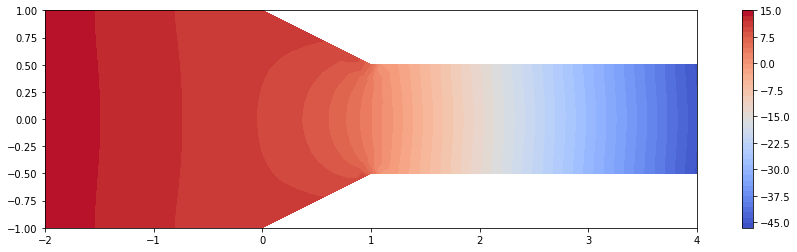

In [0]:


def calculate_pressure_drop(p_in, V, mesh):
# Outline for pressure drop calculations 
  p = project(p_in, FunctionSpace(mesh, "Lagrange", pdeg - 1))

  # Analytical velocity profile and approximated "marker function"
  velocity_in = interpolate(Expression(("(0.5*(1+tanh(K*(-x[0]))))*-x[0]/(2*bi)","0"), K = 1000, bi = lbufr, degree=4), V)
  velocity_out = interpolate(Expression(("(0.5*(1+tanh(K*(x[0]-L))))*(x[0]-L)/(2*H*b0)","0"), K = 1000, L = 1.0, H = 0.5, b0 = rbufr, degree=4), V) 


  p_avg_in_form = div(velocity_in*p)*dx(mesh)
  p_avg_in = assemble(p_avg_in_form)
  print('p_in: ', p_avg_in)

  p_avg_out_form = div(velocity_out*p)*dx(mesh) 
  p_avg_out = assemble(p_avg_out_form)
  print('p_out: ', p_avg_out)

  print('p_delta: ', p_avg_in-p_avg_out,'\n')
  return 


# I haven't really looked up the relationship between w and pressure

u_in = nst
p_in = -div(w)
calculate_pressure_drop(p_in, V, mesh)

p_in = project( -div(w), FunctionSpace(mesh, "Lagrange", pdeg - 1))
calculate_pressure_drop(p_in, V, mesh)

u_in = gold
A = 2*sym(grad(u_in))
p_in = div(wg) + (- 0.5*inner(u_in,u_in) + alfa*(dot(u_in,div(grad(u_in))) + 0.25*inner(A,A)))
calculate_pressure_drop(p_in, V, mesh)

# check if sane for NSE
fig = plt.gcf(); fig.set_size_inches(16, 4)
c = plot(p_in, cmap="coolwarm")
plt.colorbar(c)




In [0]:
plot(gold[0], interactive=True)


